In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from khmernltk import word_tokenize

In [2]:
train_df = pd.read_excel('Data\train_dataset.xlsx')
test_df = pd.read_excel('Data\test_dataset.xlsx')

In [3]:
# Tokenization (Assume each entity is a single token for simplicity)
train_df['word'] = train_df['entity']
test_df['word'] = test_df['entity']

In [4]:
def tokenize(sen): return word_tokenize(sen)

In [5]:
def extract_features(df):
    df['prefix'] = df['word'].apply(lambda x: x[:3])
    df['suffix'] = df['word'].apply(lambda x: x[-3:])
    return df

In [6]:
train_df = extract_features(train_df)
test_df = extract_features(test_df)

In [7]:
train_df

,entity,label,entity_token,prefix,suffix,word
0,ស្រុកមង្គលបូរី,PER,"['ស្រុក', 'មង្គល', 'បូរី']",ស្រ,ូរី,ស្រុកមង្គលបូរី
1,លោកវេជ្ជបណ្ឌិតកែររដ្ឋា,PER,"['លោក', 'វេជ្ជបណ្ឌិត', 'កែរ', 'រដ្ឋា']",លោក,្ឋា,លោកវេជ្ជបណ្ឌិតកែររដ្ឋា
2,សហភាពអាហ្វ្រិក,LOC,"['សហភាព', 'អាហ្វ្រិក']",សហភ,រិក,សហភាពអាហ្វ្រិក
3,\tភូមិព្រីង,LOC,"['ភូមិ', 'ព្រីង']",\tភូ,រីង,\tភូមិព្រីង
4,ក្រសួងយុត្តិធម៌,ORG,"['ក្រសួង', 'យុត្តិធម៌']",ក្រ,ធម៌,ក្រសួងយុត្តិធម៌
...,...,...,...,...,...,...
697,លោកឃាងភារម្យ,PER,"['លោក', 'ឃាង', 'ភារម្យ']",លោក,ម្យ,លោកឃាងភារម្យ
698,ជំងឺអង់ដូមេទ្រីយូស្ស,DIS,"['ជំងឺ', 'អង់ដូមេ', 'ទ្រី', 'យូស្ស']",ជំង,ស្ស,ជំងឺអង់ដូមេទ្រីយូស្ស
699,ឃុំរំចេក,LOC,"['ឃុំ', 'រំចេក']",ឃុំ,ចេក,ឃុំរំចេក
700,អ្នកស្រីនាងស្រីខួច,PER,"['អ្នកស្រី', 'នាង', 'ស្រី', 'ខួច']",អ្ន,ខួច,អ្នកស្រីនាងស្រីខួច


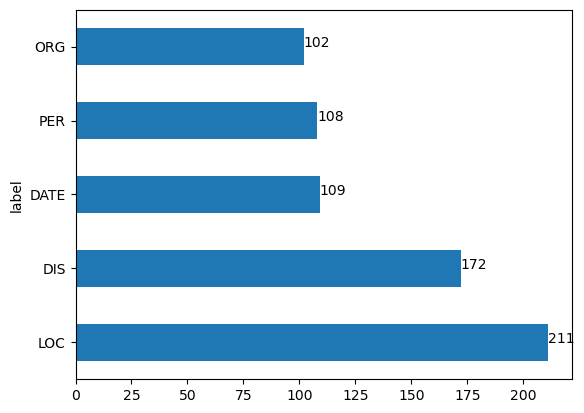

In [8]:
train_df['label'].value_counts().plot(kind='barh')
# add data label
for i, v in enumerate(train_df['label'].value_counts()):
    plt.text(v, i, str(v), color='black')
plt.show()

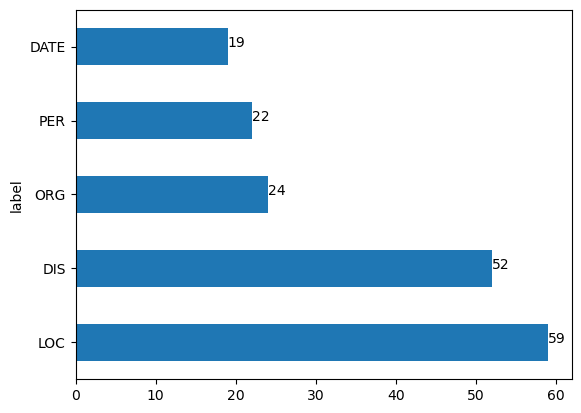

In [9]:
test_df['label'].value_counts().plot(kind='barh')
# add data label
for i, v in enumerate(test_df['label'].value_counts()):
    plt.text(v, i, str(v), color='black')
plt.show()

In [10]:
# Step 2: Convert Features to Numerical Vectors
X_train = train_df[['word', 'prefix', 'suffix']].to_dict(orient='records')
y_train = train_df['label']

X_test = test_df[['word', 'prefix', 'suffix']].to_dict(orient='records')
y_test = test_df['label']

In [11]:
len(X_train), len(X_test)

(702, 176)

In [12]:
# Step 4: Train Random Forest Model using a Pipeline
vec = DictVectorizer(sparse=False)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [13]:
pipeline = Pipeline([
    ('vectorizer', vec),
    ('classifier', rf)
])

In [14]:
# train model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', DictVectorizer(sparse=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [15]:
# Step 5: Evaluate the Model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        DATE       1.00      0.89      0.94        19
         DIS       0.96      0.83      0.89        52
         LOC       0.71      0.92      0.80        59
         ORG       0.79      0.62      0.70        24
         PER       1.00      0.86      0.93        22

    accuracy                           0.84       176
   macro avg       0.89      0.83      0.85       176
weighted avg       0.86      0.84      0.84       176



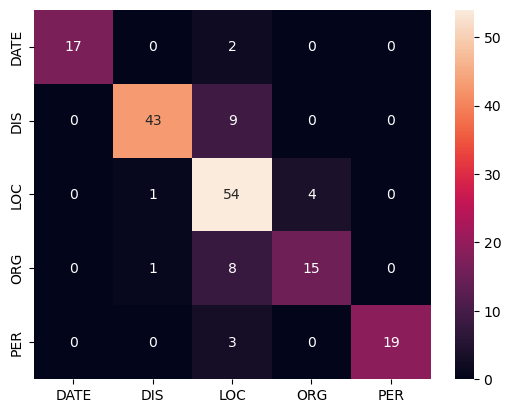

In [16]:
# display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# add class name in heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.show()

In [17]:
# create a function for testing unseen data
# def predict_label(text):
#     X = extract_features(pd.DataFrame({'word': [text]}))
#     X = X[['word', 'prefix', 'suffix']].to_dict(orient='records')
#     pred_label = pipeline.predict(X)[0]
#     return pred_label

In [18]:
def predict_label(text, threshold=0.75):
    # Extract features from the input text
    X = extract_features(pd.DataFrame({'word': [text]}))
    X = X[['word','prefix', 'suffix']].to_dict(orient='records')
    
    # Get the probability estimates for each class
    pred_proba = pipeline.predict_proba(X)[0]
    
    # Get the predicted label and its confidence score
    max_proba = max(pred_proba)
    pred_label = pipeline.classes_[pred_proba.argmax()]
    
    # Check if the confidence is above the threshold
    # print(max_proba)
    if max_proba >= threshold:
        return pred_label
    else:
        return 'Unknown Class'  # or 'unknown' for entities outside your 5 classes

In [19]:
print(predict_label("ជំទាវ"))

Unknown Class


In [20]:
def tokenize(sen): 
    tokens = word_tokenize(sen)
    # remove element that is equal space
    tokens = [t for t in tokens if t != ' ']
    tokens = [i for i in tokens if i]
    return tokens

In [21]:
def input(sen):
    result = []
    tokens = tokenize(sen)
    bi_gram_tokens = []
    # implement Bi-gram
    # for i in range(len(tokens)-1):
    #     bi_gram_tokens.append(tokens[i] + tokens[i+1])
    for token in tokens:
        result.append((token, predict_label(token)))
    # print(result)
    return result

In [22]:
test = "ក្រសួង​សុខាភិ​បាល​កម្ពុជា​បាន​ប្រកាសរក​ឃើញ​ជំងឺ​អឹម​ផក"

In [23]:
re = input(test)

for x in re:
    print(x)

| 2024-09-15 01:10:10,677 | INFO | khmer-nltk | Loaded model from c:\Users\ASUS\anaconda3\Lib\site-packages\khmernltk\word_tokenize\sklearn_crf_ner_10000.sav |


('ក្រសួង', 'ORG')
('សុខាភិបាល', 'Unknown Class')
('កម្ពុជា', 'ORG')
('បាន', 'Unknown Class')
('ប្រកាស', 'LOC')
('រកឃើញ', 'Unknown Class')
('ជំងឺ', 'DIS')
('អឹម', 'Unknown Class')
('ផក', 'Unknown Class')
